# 🎨 BRK-A-01 Results Visualization

Notebook per la visualizzazione 3D avanzata dei risultati di topology optimization.

**Input:** Risultati salvati da `main.py` in `data/brk_a_01/`

---

## 1. Setup e Import

In [1]:
import sys
sys.path.insert(0, '..')

import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# 3D Visualization
try:
    import pyvista as pv
    pv.set_jupyter_backend('static')  # Use 'trame' for interactive
    PYVISTA_AVAILABLE = True
    print("✓ PyVista disponibile per visualizzazione 3D avanzata")
except ImportError:
    PYVISTA_AVAILABLE = False
    print("⚠ PyVista non installato. Installa con: pip install pyvista")

try:
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    PLOTLY_AVAILABLE = True
    print("✓ Plotly disponibile per visualizzazione interattiva")
except ImportError:
    PLOTLY_AVAILABLE = False
    print("⚠ Plotly non installato. Installa con: pip install plotly")

print("\nImports completati ✓")

✓ PyVista disponibile per visualizzazione 3D avanzata
✓ Plotly disponibile per visualizzazione interattiva

Imports completati ✓


## 2. Carica Risultati da main.py

In [2]:
# Percorso ai risultati
data_dir = Path('../data/brk_a_01')

# Carica metadata
with open(data_dir / 'metadata.json', 'r') as f:
    metadata = json.load(f)

# Carica campo di densità
density = np.load(data_dir / 'density_field.npy')

# Mostra informazioni
print("📂 Risultati caricati da:", data_dir)
print("\n📊 Metadata:")
for key, value in metadata.items():
    if isinstance(value, float):
        print(f"   {key}: {value:.4f}")
    else:
        print(f"   {key}: {value}")

print(f"\n📐 Campo densità:")
print(f"   Shape: {density.shape}")
print(f"   Min: {density.min():.4f}")
print(f"   Max: {density.max():.4f}")
print(f"   Mean: {density.mean():.4f}")

📂 Risultati caricati da: ../data/brk_a_01

📊 Metadata:
   case: BRK-A-01
   mode: cpp
   resolution_mm: 5.0000
   domain_shape: [24, 12, 16]
   volume_fraction_target: 0.2500
   volume_fraction_final: 0.2500
   compliance_final: 136.1621
   iterations: 50
   converged: False
   elapsed_time_s: 55.5478
   openmp_threads: 10
   simp_config: {'filter_radius': 3.5, 'E_min': 0.0001, 'penalty': 3.0, 'move_limit': 0.1}

📐 Campo densità:
   Shape: (24, 12, 16)
   Min: 0.0100
   Max: 1.0000
   Mean: 0.2500


## 3. Slice Views (Matplotlib)

/var/folders/j4/lw9rt9517k134dz28rgq71r40000gn/T/ipykernel_21920/3492871582.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


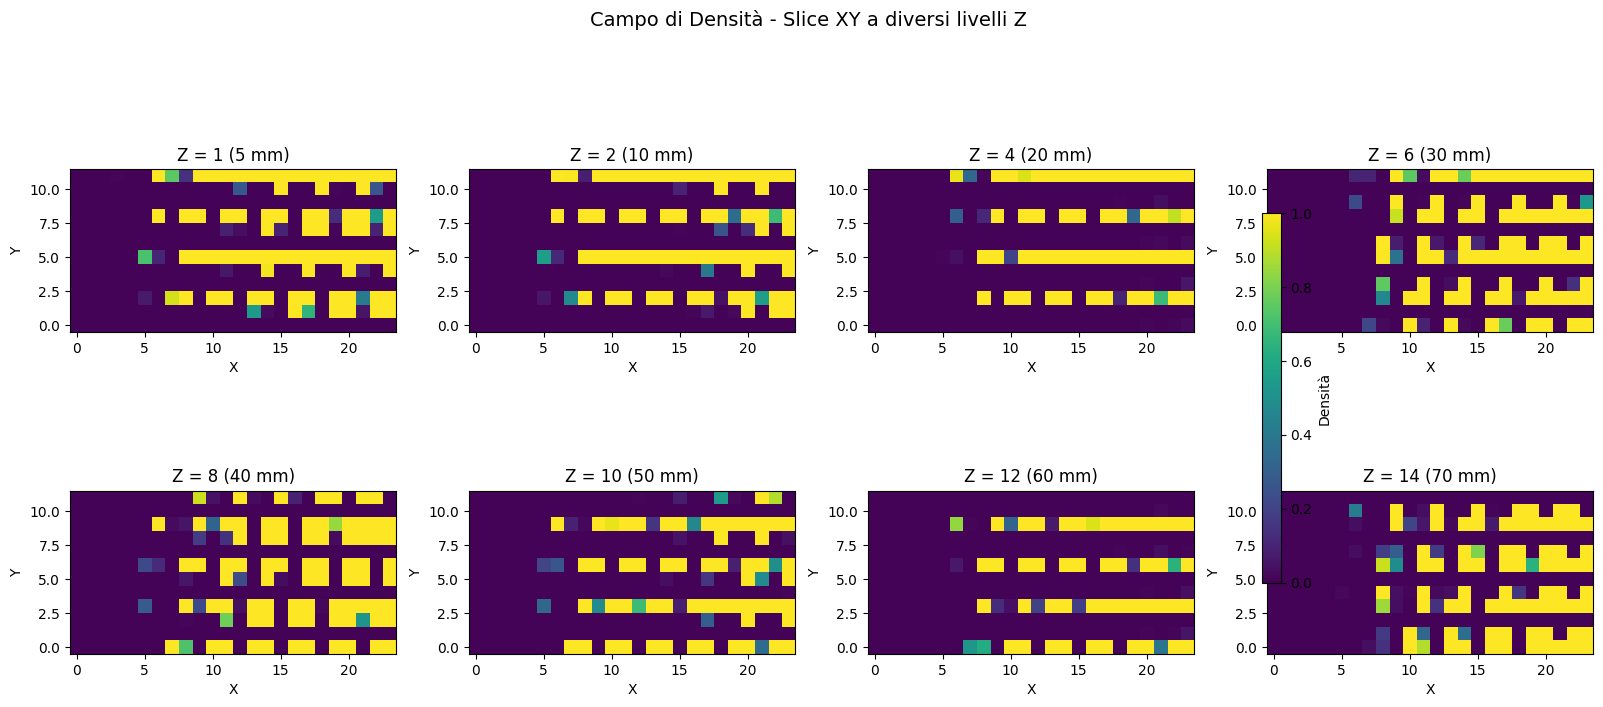

In [3]:
# Visualizza slice a diversi livelli
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

nz = density.shape[2]
z_levels = np.linspace(1, nz-2, 8).astype(int)

for ax, z in zip(axes.flat, z_levels):
    im = ax.imshow(density[:, :, z].T, cmap='viridis', 
                   vmin=0, vmax=1, origin='lower', aspect='equal')
    ax.set_title(f'Z = {z} ({z * metadata["resolution_mm"]:.0f} mm)')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

plt.colorbar(im, ax=axes, label='Densità', shrink=0.6)
plt.suptitle('Campo di Densità - Slice XY a diversi livelli Z', fontsize=14)
plt.tight_layout()
plt.show()

## 4. Isosurface 3D con Matplotlib

/var/folders/j4/lw9rt9517k134dz28rgq71r40000gn/T/ipykernel_21920/1932031059.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


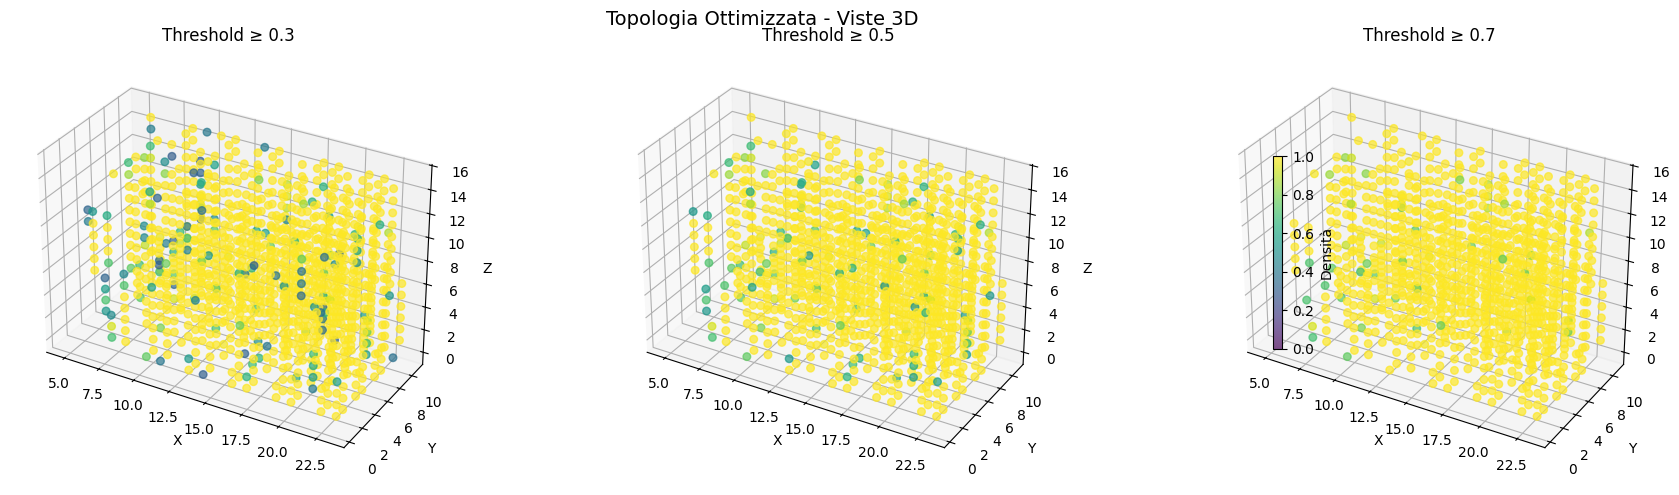

Threshold 0.3: 1,150 voxel (25.0%)
Threshold 0.5: 1,100 voxel (23.9%)
Threshold 0.7: 1,054 voxel (22.9%)


In [4]:
from mpl_toolkits.mplot3d import Axes3D

# Estrai voxel solidi a diverse soglie
thresholds = [0.3, 0.5, 0.7]

fig = plt.figure(figsize=(18, 5))

for idx, threshold in enumerate(thresholds):
    ax = fig.add_subplot(1, 3, idx + 1, projection='3d')
    
    solid = density >= threshold
    x, y, z = np.where(solid)
    
    # Subsampling per performance
    max_points = 3000
    if len(x) > max_points:
        idx_sample = np.random.choice(len(x), max_points, replace=False)
        x, y, z = x[idx_sample], y[idx_sample], z[idx_sample]
    
    colors = density[x, y, z]
    scatter = ax.scatter(x, y, z, c=colors, cmap='viridis', 
                         s=30, alpha=0.7, vmin=0, vmax=1)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'Threshold ≥ {threshold}')
    ax.set_box_aspect([density.shape[0], density.shape[1], density.shape[2]])

plt.colorbar(scatter, ax=fig.axes, label='Densità', shrink=0.5)
plt.suptitle('Topologia Ottimizzata - Viste 3D', fontsize=14)
plt.tight_layout()
plt.show()

# Statistiche
for t in thresholds:
    n_solid = np.sum(density >= t)
    pct = n_solid / density.size * 100
    print(f"Threshold {t}: {n_solid:,} voxel ({pct:.1f}%)")

## 5. Visualizzazione 3D Avanzata con PyVista

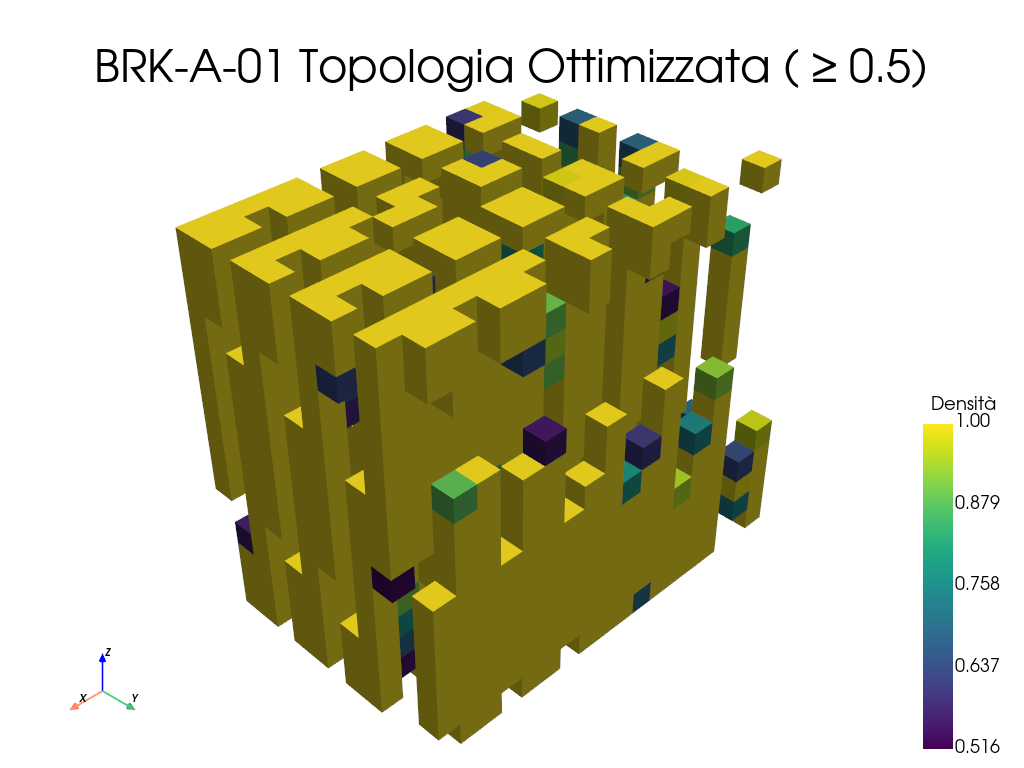

In [5]:
if PYVISTA_AVAILABLE:
    # Crea griglia strutturata
    resolution = metadata['resolution_mm']
    nx, ny, nz = density.shape
    
    # Crea coordinate per la griglia
    x = np.arange(0, (nx + 1) * resolution, resolution)
    y = np.arange(0, (ny + 1) * resolution, resolution)
    z = np.arange(0, (nz + 1) * resolution, resolution)
    
    # Crea ImageData (griglia uniforme)
    grid = pv.ImageData(
        dimensions=(nx + 1, ny + 1, nz + 1),
        spacing=(resolution, resolution, resolution),
        origin=(0, 0, 0)
    )
    
    # Aggiungi densità come dati delle celle
    grid.cell_data['density'] = density.flatten(order='F')
    
    # Threshold per estrarre solo materiale solido
    threshold = 0.5
    solid = grid.threshold(threshold, scalars='density')
    
    # Plotter
    pl = pv.Plotter()
    pl.add_mesh(solid, scalars='density', cmap='viridis', 
                show_edges=False, opacity=1.0,
                scalar_bar_args={'title': 'Densità', 'vertical': True})
    pl.add_axes()
    pl.add_title(f'BRK-A-01 Topologia Ottimizzata (ρ ≥ {threshold})')
    pl.camera_position = 'iso'
    pl.show()
else:
    print("⚠ PyVista non disponibile. Installa con: pip install pyvista")

## 6. Isosurface con PyVista

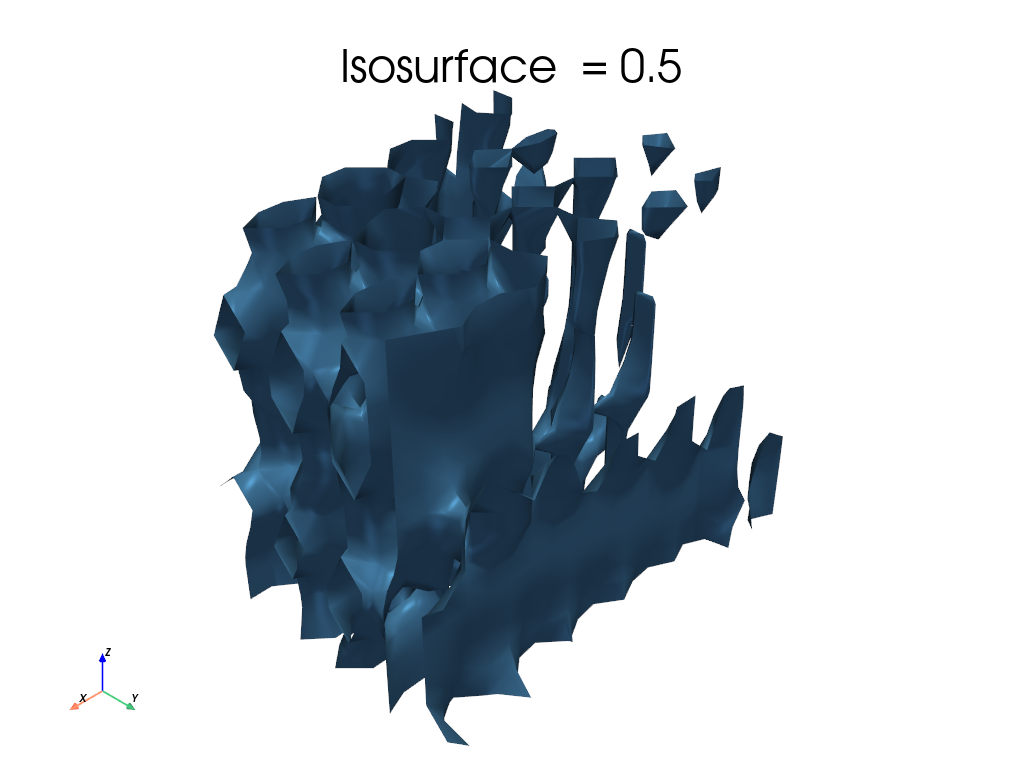

In [6]:
if PYVISTA_AVAILABLE:
    # Converti cell data a point data per isosurface smooth
    grid_points = grid.cell_data_to_point_data()
    
    # Genera isosurface a ρ = 0.5
    iso_value = 0.5
    isosurface = grid_points.contour([iso_value], scalars='density')
    
    # Smooth per migliorare qualità visiva
    isosurface_smooth = isosurface.smooth(n_iter=50)
    
    # Plot
    pl = pv.Plotter()
    pl.add_mesh(isosurface_smooth, color='steelblue', 
                show_edges=False, smooth_shading=True,
                specular=0.5, specular_power=20)
    pl.add_axes()
    pl.add_title(f'Isosurface ρ = {iso_value}')
    pl.camera_position = 'iso'
    pl.show()
else:
    print("⚠ PyVista non disponibile")

## 7. Multi-Isosurface (Visualizzazione Gradiente)

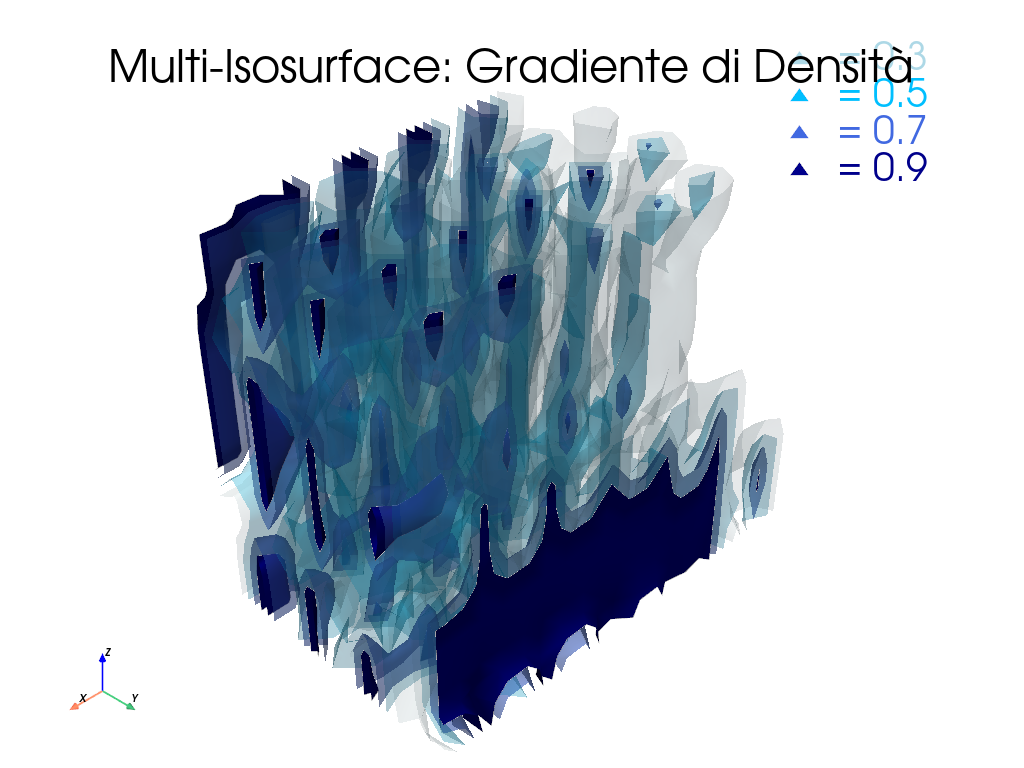

In [7]:
if PYVISTA_AVAILABLE:
    pl = pv.Plotter()
    
    # Isosurfaces a diversi livelli con opacità crescente
    iso_levels = [0.3, 0.5, 0.7, 0.9]
    opacities = [0.15, 0.3, 0.6, 1.0]
    colors = ['lightblue', 'deepskyblue', 'royalblue', 'darkblue']
    
    for iso_val, opacity, color in zip(iso_levels, opacities, colors):
        try:
            iso = grid_points.contour([iso_val], scalars='density')
            if iso.n_points > 0:
                iso_smooth = iso.smooth(n_iter=30)
                pl.add_mesh(iso_smooth, color=color, opacity=opacity,
                            smooth_shading=True, label=f'ρ = {iso_val}')
        except Exception as e:
            print(f"Skip iso {iso_val}: {e}")
    
    pl.add_axes()
    pl.add_legend()
    pl.add_title('Multi-Isosurface: Gradiente di Densità')
    pl.camera_position = 'iso'
    pl.show()
else:
    print("⚠ PyVista non disponibile")

## 8. Visualizzazione Interattiva con Plotly

In [8]:
if PLOTLY_AVAILABLE:
    # Estrai voxel con densità > threshold
    threshold = 0.5
    resolution = metadata['resolution_mm']
    
    x, y, z = np.where(density >= threshold)
    values = density[x, y, z]
    
    # Converti in mm
    x_mm = x * resolution
    y_mm = y * resolution
    z_mm = z * resolution
    
    # Subsampling per performance
    max_points = 5000
    if len(x_mm) > max_points:
        idx = np.random.choice(len(x_mm), max_points, replace=False)
        x_mm, y_mm, z_mm, values = x_mm[idx], y_mm[idx], z_mm[idx], values[idx]
    
    # Crea scatter 3D
    fig = go.Figure(data=[go.Scatter3d(
        x=x_mm, y=y_mm, z=z_mm,
        mode='markers',
        marker=dict(
            size=4,
            color=values,
            colorscale='Viridis',
            colorbar=dict(title='Densità'),
            opacity=0.8
        ),
        hovertemplate='X: %{x:.1f} mm<br>Y: %{y:.1f} mm<br>Z: %{z:.1f} mm<br>ρ: %{marker.color:.3f}<extra></extra>'
    )])
    
    fig.update_layout(
        title=f'BRK-A-01 Topologia Ottimizzata (ρ ≥ {threshold})',
        scene=dict(
            xaxis_title='X (mm)',
            yaxis_title='Y (mm)',
            zaxis_title='Z (mm)',
            aspectmode='data'
        ),
        width=900,
        height=700
    )
    
    fig.show()
else:
    print("⚠ Plotly non disponibile. Installa con: pip install plotly")

## 9. Volume Rendering con PyVista

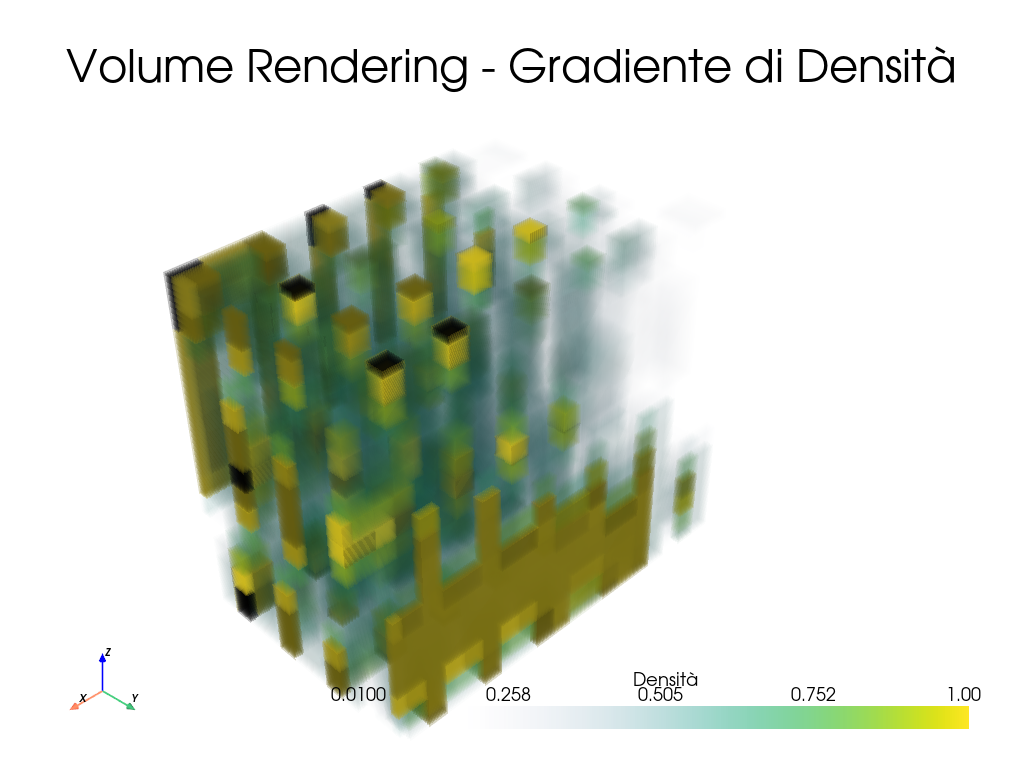

In [9]:
if PYVISTA_AVAILABLE:
    # Volume rendering per visualizzare il gradiente interno
    pl = pv.Plotter()
    
    # Opacity transfer function
    opacity = [0, 0, 0.1, 0.3, 0.6, 0.9, 1.0]
    
    pl.add_volume(grid, scalars='density', cmap='viridis',
                  opacity=opacity, shade=True,
                  scalar_bar_args={'title': 'Densità'})
    pl.add_axes()
    pl.add_title('Volume Rendering - Gradiente di Densità')
    pl.camera_position = 'iso'
    pl.show()
else:
    print("⚠ PyVista non disponibile")

## 11. Export STL per Stampa 3D

✅ Mesh STL salvata: ../data/brk_a_01/brk_a_01_optimized.stl
   Vertici: 2,436
   Facce: 4,483
   Volume: 181747.64 mm³


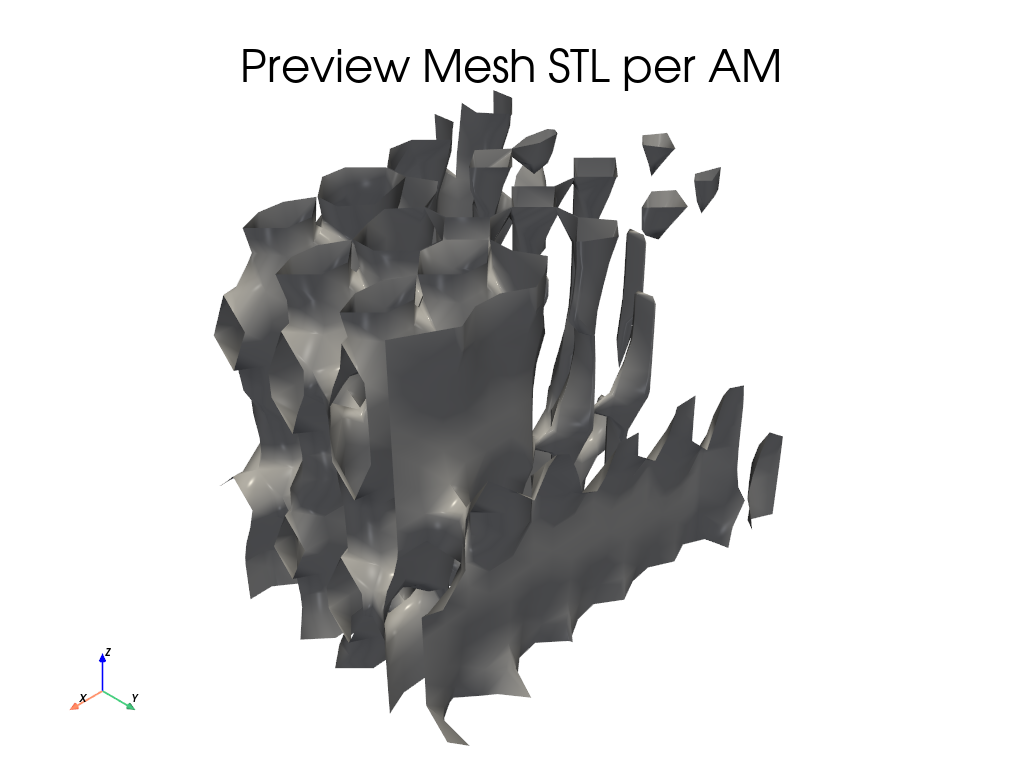

In [10]:
if PYVISTA_AVAILABLE:
    # Genera mesh STL dalla isosurface
    iso_value = 0.5
    
    # Genera isosurface
    grid_points = grid.cell_data_to_point_data()
    isosurface = grid_points.contour([iso_value], scalars='density')
    
    # Smooth e clean
    mesh_clean = isosurface.smooth(n_iter=50).clean()
    
    # Salva STL
    stl_path = data_dir / 'brk_a_01_optimized.stl'
    mesh_clean.save(stl_path)
    
    print(f"✅ Mesh STL salvata: {stl_path}")
    print(f"   Vertici: {mesh_clean.n_points:,}")
    print(f"   Facce: {mesh_clean.n_cells:,}")
    print(f"   Volume: {mesh_clean.volume:.2f} mm³")
    
    # Mostra preview
    pl = pv.Plotter()
    pl.add_mesh(mesh_clean, color='silver', show_edges=False,
                smooth_shading=True, specular=0.5)
    pl.add_axes()
    pl.add_title('Preview Mesh STL per AM')
    pl.show()
else:
    print("⚠ PyVista necessario per export STL")

---

## 📝 Note

- **PyVista** offre rendering 3D di alta qualità con isosurface, volume rendering e slice
- **Plotly** permette visualizzazioni interattive nel browser
- Per visualizzazione interattiva completa in PyVista, usa `pv.set_jupyter_backend('trame')`
- L'export STL genera mesh pronte per software di slicing (Cura, PrusaSlicer, etc.)

## 🔍 Debug: Test Sensitività a Bassa Risoluzione

Eseguiamo una singola iterazione a risoluzione bassissima per verificare i valori delle sensitività.

In [13]:
# Debug: Test a risoluzione bassissima per verificare sensitività
import sys
sys.path.insert(0, '..')

import numpy as np

# Import C++ engine
try:
    from src.am.cpp import (
        CPPTopologyOptimizer, MaterialProperties, SIMPConfig,
        get_max_threads, is_available
    )
    from src.am.core.geometry import create_bracket_domain
    from src.am.core.loads import create_brk_a_01_static_case_1
    
    if not is_available():
        raise ImportError("C++ engine not available")
    
    print(f"✓ C++ Engine loaded, OpenMP threads: {get_max_threads()}")
    
    # Risoluzione MOLTO bassa per debug rapido
    resolution = 12.0  # mm -> griglia ~10x5x7
    
    domain = create_bracket_domain(
        size_mm=(120, 60, 80),
        resolution_mm=resolution
    )
    nx, ny, nz = domain.shape
    print(f"\n📐 Domain: {nx}x{ny}x{nz} = {nx*ny*nz} elementi")
    
    # Load case
    load_case = create_brk_a_01_static_case_1(domain.shape, resolution)
    
    # Material
    material = MaterialProperties()
    
    # Config con parametri stabili
    config = SIMPConfig()
    config.volume_fraction = 0.3
    config.max_iterations = 3  # Solo 3 iterazioni per debug
    config.verbose = True
    config.filter_radius = 1.5
    config.E_min = 1e-3  # Molto alto per stabilità
    config.move_limit = 0.1
    
    print(f"\n⚙️ Config: E_min={config.E_min:.0e}, filter_radius={config.filter_radius}")
    
    # Prepara input
    element_size = resolution / 1000.0
    
    initial_density = []
    for i in range(nx):
        for j in range(ny):
            for k in range(nz):
                if domain.grid[i, j, k] == 0:
                    initial_density.append(config.volume_fraction)
                elif domain.grid[i, j, k] == 1:
                    initial_density.append(1.0)
                else:
                    initial_density.append(0.0)
    
    n_nodes = (nx + 1) * (ny + 1) * (nz + 1)
    n_dofs = 3 * n_nodes
    forces = load_case.get_force_vector(n_dofs)
    fixed_dofs = load_case.get_constrained_dofs().tolist()
    
    print(f"\n🔢 DOFs: {n_dofs}, Fixed DOFs: {len(fixed_dofs)}")
    print(f"   Force max: {np.max(np.abs(forces)):.2f} N")
    
    # Crea optimizer e run
    print("\n" + "="*50)
    optimizer = CPPTopologyOptimizer(
        nx, ny, nz, element_size, material, config
    )
    
    result = optimizer.run(initial_density, forces, fixed_dofs)
    
    # Analisi risultati
    print("\n" + "="*50)
    print("📊 ANALISI RISULTATI")
    print("="*50)
    
    density_final = np.array(result.final_density)
    print(f"\nDensità finale:")
    print(f"   Shape: {density_final.shape}")
    print(f"   Min: {density_final.min():.6f}")
    print(f"   Max: {density_final.max():.6f}")
    print(f"   Mean: {density_final.mean():.6f}")
    
    print(f"\nCompliance history: {result.compliance_history}")
    print(f"Volume history: {result.volume_history}")
    print(f"Converged: {result.converged}")
    print(f"Iterations: {result.iterations}")
    
    # Check per anomalie
    if len(result.compliance_history) > 1:
        c0, c1 = result.compliance_history[0], result.compliance_history[-1]
        if c1 > c0 * 1.5:
            print(f"\n⚠️ ANOMALIA: Compliance AUMENTATA da {c0:.4e} a {c1:.4e}")
        else:
            print(f"\n✓ Compliance trend: {c0:.4e} → {c1:.4e}")
    
except ImportError as e:
    print(f"❌ Errore import: {e}")
except Exception as e:
    print(f"❌ Errore: {e}")
    import traceback
    traceback.print_exc()

✓ C++ Engine loaded, OpenMP threads: 10

📐 Domain: 10x5x6 = 300 elementi

⚙️ Config: E_min=1e-03, filter_radius=1.5

🔢 DOFs: 1386, Fixed DOFs: 198
   Force max: 15000.00 N

  Filter build time: 0 ms
  Average neighbors: 14.6
TopologyOptimizer initialized:
  Grid: 10 x 5 x 6
  Elements: 300
  DOFs: 1386
  Filter radius: 1.5
  Volume fraction: 0.3

SIMP Topology Optimization
  Iter    Compliance       Vol      Change   CG Iter      Time
--------------------------------------------------------------
     0    1.4400e+00     0.314    1.00e-01        33      0.01s
     1    2.5183e+00     0.300    1.00e-01        33      0.02s
     2    1.9712e+00     0.300    1.00e-01        37      0.02s
Optimization completed
  Iterations: 3
  Final compliance: 1.97
  Final volume: 0.30
  Total time: 0.05 s

📊 ANALISI RISULTATI

Densità finale:
   Shape: (300,)
   Min: 0.010000
   Max: 1.000000
   Mean: 0.300000

Compliance history: [1.440006209452606, 2.5182595401031365, 1.971215740189977]
Volume histor

In [12]:
# Test singola iterazione per vedere statistiche dettagliate
print("🔬 Test Singola Iterazione con runIteration()")
print("="*50)

# Ricrea optimizer con densità uniforme
config2 = SIMPConfig()
config2.volume_fraction = 0.3
config2.max_iterations = 1
config2.verbose = True  # Importante per vedere i dettagli
config2.filter_radius = 1.5
config2.E_min = 1e-3
config2.move_limit = 0.1

optimizer2 = CPPTopologyOptimizer(
    nx, ny, nz, element_size, material, config2
)

# Densità iniziale uniforme
density_test = [config2.volume_fraction if domain.grid[i, j, k] == 0 
                else (1.0 if domain.grid[i, j, k] == 1 else 0.0)
                for i in range(nx) for j in range(ny) for k in range(nz)]

print(f"\nDensità iniziale: min={min(density_test):.4f}, max={max(density_test):.4f}, mean={np.mean(density_test):.4f}")

# Esegui singola iterazione
iter_result = optimizer2.run_iteration(density_test, forces, fixed_dofs)

print(f"\n📊 Risultato iterazione:")
print(f"   Compliance: {iter_result.compliance:.6e}")
print(f"   Volume fraction: {iter_result.volume_fraction:.6f}")
print(f"   Max density change: {iter_result.max_density_change:.6f}")
print(f"   CG iterations: {iter_result.solver_iterations}")
print(f"   Assembly time: {iter_result.assembly_time_s:.4f} s")
print(f"   Solve time: {iter_result.solve_time_s:.4f} s")
print(f"   Sensitivity time: {iter_result.sensitivity_time_s:.4f} s")
print(f"   Update time: {iter_result.update_time_s:.4f} s")

# Analizza densità dopo update
density_after = np.array(density_test)
print(f"\nDensità dopo iterazione:")
print(f"   min={density_after.min():.4f}, max={density_after.max():.4f}, mean={density_after.mean():.4f}")

# Conta elementi che sono cambiati
n_changed = np.sum(np.abs(density_after - config2.volume_fraction) > 0.001)
print(f"   Elementi modificati: {n_changed}/{len(density_after)}")

🔬 Test Singola Iterazione con runIteration()

Densità iniziale: min=0.0000, max=1.0000, mean=0.4117

📊 Risultato iterazione:
   Compliance: 1.440006e+00
   Volume fraction: 0.313500
   Max density change: 0.100000
   CG iterations: 33
   Assembly time: 0.0006 s
   Solve time: 0.0070 s
   Sensitivity time: 0.0001 s
   Update time: 0.0008 s

Densità dopo iterazione:
   min=0.0000, max=1.0000, mean=0.4117
   Elementi modificati: 55/300
  Filter build time: 0 ms
  Average neighbors: 14.6
TopologyOptimizer initialized:
  Grid: 10 x 5 x 6
  Elements: 300
  DOFs: 1386
  Filter radius: 1.5
  Volume fraction: 0.3
